# Notebook de modélisation
## Adrian Rodriguez
## Projet 4 parcours Ingénieur Machine Learning
Accès projet git : https://github.com/Adrian1903/Categorisez-automatiquement-des-questions   
Plus d'informations : https://openclassrooms.com/fr/paths/148-ingenieur-machine-learning

---
# 0. Contexte

Stack Overflow est un site célèbre de questions-réponses liées au développement informatique. Pour poser une question sur ce site, il faut entrer plusieurs tags de manière à retrouver facilement la question par la suite. Pour les utilisateurs expérimentés, cela ne pose pas de problème, mais pour les nouveaux utilisateurs, il serait judicieux de suggérer quelques tags relatifs à la question posée.

Amateur de Stack Overflow, qui vous a souvent sauvé la mise, vous décidez d'aider la communauté en retour. Pour cela, vous développez un système de suggestion de tag pour le site. Celui-ci prendra la forme d’un algorithme de machine learning qui assigne automatiquement plusieurs tags pertinents à une question.

Les données
Stack Overflow propose un outil d’export de données - "stackexchange explorer", qui recense un grand nombre de données authentiques de la plateforme d’entraide. 

Contraintes :
- Mettre en œuvre une approche non supervisée.
- Utiliser une approche supervisée ou non pour extraire des tags à partir des résultats précédents.
- Comparer ses résultats à une approche purement supervisée, après avoir appliqué des méthodes d’extraction de features spécifiques des données textuelles.
- Mettre en place une méthode d’évaluation propre, avec une séparation du jeu de données pour l’évaluation.
- Pour suivre les modifications du code final à déployer, utiliser un logiciel de gestion de versions, par exemple Git.

In [1]:
import pandas as pd
pd.options.display.max_columns = None


from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer


from sklearn.model_selection import train_test_split

from sklearn.decomposition import LatentDirichletAllocation

from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import jaccard_score

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("default")
import pyLDAvis.sklearn

from functions import *

import time

import warnings
warnings.filterwarnings('ignore')

---
# 1. Importation et exploration préliminaire


In [2]:
questions_raw = pd.read_csv('src/cleaned_questions.csv')

In [3]:
questions_raw.head()

,Id,Tags,Title_Body,Cleaned_Title_Body
0,63087217,"rust,reference",Changes using mutable reference of a field are...,change mutable reference field reflect origina...
1,63078532,javascript,Is it possible to create a new data type in Ja...,possible new data type javascript possible new...
2,63067062,elasticsearch,Elastic Search indexes gets deleted frequently...,elastic search index delete frequently elastic...
3,63046397,"c++,if_statement,templates,c++17,constexpr",Why does this usage of C++17 if constexpr fail...,usage c++17 constexpr try c++17 constexpr cond...
4,63043585,"java,visual_studio_code","VSCode showing ""Java 11 or more recent is requ...",java recent require download recent jdk start ...


In [4]:
questions_raw.shape

(49134, 4)

In [5]:
questions_raw.columns

Index(['Id', 'Tags', 'Title_Body', 'Cleaned_Title_Body'], dtype='object')

In [6]:
questions_raw.isna().sum()

Id                    0
Tags                  1
Title_Body            0
Cleaned_Title_Body    3
dtype: int64

In [7]:
questions = questions_raw.copy()

In [8]:
questions[questions.Cleaned_Title_Body.isna()]

,Id,Tags,Title_Body,Cleaned_Title_Body
19762,41069330,"javascript,html","With <script crossorigin='anonymous'>, why is ...",NaN
26407,38143580,"html,css",When should <script> tags be visible and why c...,NaN
46366,30727084,"javascript,jquery,autocomplete",Make <a> inside jQuery autocomplete clickable ...,NaN


In [9]:
# Je limite le nombre d'observation pour la phase de dev
questions = questions.head(10000)

# 2. Classification non supervisée avec LDA
Méthode : 
- 1/ Création du vecteur de mots
- 2/ Calcul du nombre de sujet idéal
- 3/ Formation du modèle
- 4/ Vérification des résultats

In [13]:
corpus = questions.Cleaned_Title_Body

## Création du vecteur de mots

In [14]:
count_vectorizer = CountVectorizer()
feature_matrix = count_vectorizer.fit_transform(corpus)
display(feature_matrix.shape)

(10000, 20338)

## Détermination du nombre de sujet idéal

In [ ]:
results = pd.DataFrame()
tmp_result = pd.DataFrame(index = range(1))
for i in np.arange(5, 70, 5):
    print(f'{i} composants en cours de traitement...')
    lda_model = LatentDirichletAllocation(n_components=i, random_state=123)

    lda_model.fit_transform(feature_matrix)

    tmp_result['n_components'] = i
    tmp_result['log_likelihood'] = lda_model.score(feature_matrix)
    tmp_result['perplexity'] = lda_model.perplexity(feature_matrix)

    results = results.append(tmp_result)

results

In [ ]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()

ax1.bar(results.n_components,
        results.perplexity,
        color='darkblue')
ax2.plot(results.n_components,
         results.log_likelihood,
         'o-',
         color="firebrick")
min_y = int(results.perplexity.min()/100)*100
max_y = int((results.perplexity.max()+100)/100)*100
ax1.set_ylim(min_y, max_y)
ax1.set_xlabel('Nombre de sujets')
ax1.set_ylabel('Perplexité', color='darkblue')
ax2.set_ylabel('Probabilité logarithmique', color='firebrick')
plt.title('Evaluation du modèle LDA')
plt.savefig('img/img_LDA_evaluation.png',
            transparent=True)
plt.show()

Je cherche à avoir la probabilité logarithmique la plus élevée et une moindre perplexité.

## Formation du modèle

In [ ]:
min_perp = results.perplexity.min()
n_comp = results[results.perplexity == min_perp].n_components.item()
print(f'Le nombre de sujet idéal est de {n_comp}')
# Je forme le modèle
lda = LatentDirichletAllocation(n_components=n_comp, random_state=123)
lda_out = lda.fit_transform(feature_matrix)

In [15]:
# Temporaire : pour éviter de relancer le calcul à chaque essai
lda = LatentDirichletAllocation(n_components=15, random_state=123)
%time lda_out = lda.fit_transform(feature_matrix)

Wall time: 29 s


In [16]:
# Sujet dominants dans chaque documents
doc_topic = get_doc_topic(lda, corpus, lda_out)
doc_topic

,Topic_#0,Topic_#1,Topic_#2,Topic_#3,Topic_#4,Topic_#5,Topic_#6,Topic_#7,Topic_#8,Topic_#9,Topic_#10,Topic_#11,Topic_#12,Topic_#13,Topic_#14
0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.97,0.00,0.00,0.0,0.0
1,0.0,0.0,0.24,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.71,0.00,0.00,0.0,0.0
2,0.0,0.0,0.00,0.00,0.54,0.26,0.00,0.0,0.00,0.00,0.00,0.17,0.00,0.0,0.0
3,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.95,0.00,0.00,0.0,0.0
4,0.0,0.0,0.00,0.00,0.00,0.81,0.00,0.0,0.00,0.00,0.00,0.00,0.16,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.0,0.0,0.66,0.31,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.0,0.0
9996,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.0,0.93,0.00,0.00,0.00,0.00,0.0,0.0
9997,0.0,0.0,0.31,0.00,0.00,0.00,0.00,0.0,0.00,0.48,0.19,0.00,0.00,0.0,0.0
9998,0.0,0.0,0.13,0.00,0.00,0.00,0.34,0.0,0.00,0.00,0.51,0.00,0.00,0.0,0.0


<Figure size 640x480 with 0 Axes>

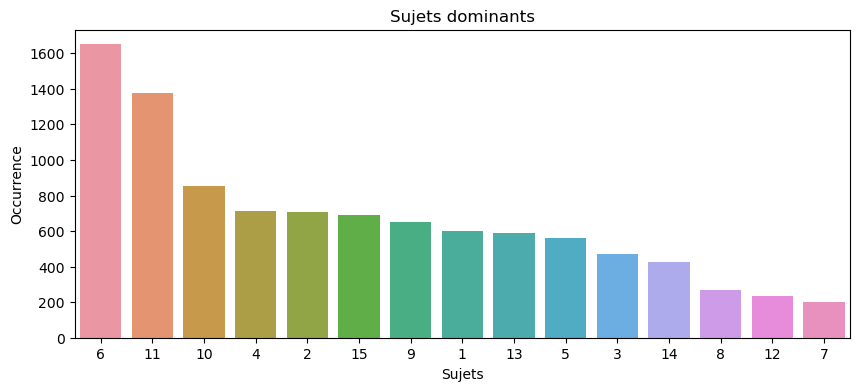

In [17]:
dominant_topic = doc_topic.copy()
dominant_topic['dominant_topic'] = np.argmax(dominant_topic.values, axis=1) + 1
order = dominant_topic.groupby('dominant_topic')['Topic_#1'].count().sort_values(ascending=False).index

plt.clf()
plt.figure(figsize=(10,4))
sns.countplot(dominant_topic.dominant_topic, order=order)
plt.title('Sujets dominants')
plt.xlabel('Sujets')
plt.ylabel('Occurrence')
plt.savefig('img/img_dominant_topic.png',
            transparent=True)

In [ ]:
# Top mots clés des différents sujets.
topic_keywords = show_topics(count_vectorizer, lda, 5)
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word ' + str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic_#' + str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

In [ ]:
panel = pyLDAvis.sklearn.prepare(lda, feature_matrix, count_vectorizer, mds='tsne')
pyLDAvis.save_html(panel, 'img/lda.html')
pyLDAvis.display(panel)

## Vérification des résultats
A partir des sujets dominants dans chaque documents et des 5 mots clés principaux de chaque sujets dominants, je constitue une suggestion de tags non supervisée.

In [ ]:
pred_tag = get_unsupervised_tag(doc_topic, df_topic_keywords, corpus)
questions = pd.merge(questions, pred_tag, left_index=True, right_index=True)
questions

---
---

# Classification supervisée
Je reprends le modèle réduit avec LDA et mes tags indiqué par l'utilisateur

In [12]:
corpus = questions.Cleaned_Title_Body
# Vectorisation des données
tfidf_vectorizer = TfidfVectorizer()
tfidf_feature_matrix = tfidf_vectorizer.fit_transform(corpus)
tfidf_feature_matrix.shape

(10000, 20338)

In [13]:
# Vectorisation des targets
mlb = MultiLabelBinarizer()
target = questions.Tags
target = [set(i.split(',')) for i in target]
target = mlb.fit_transform(target)
target.shape

(10000, 920)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(tfidf_feature_matrix, target, test_size=0.2, random_state=123)

In [17]:
classifiers = [('LogisticRegression',
                LogisticRegression(penalty='l1', solver='liblinear'),
                [{'estimator__C': [1, 10, 100]}]),

              ('LinearSVC',
               LinearSVC(penalty='l1', dual=False),
               [{'estimator__C': [1, 10, 100]}]), 

              ('SGD',
               SGDClassifier(penalty='l1'),
               [{'estimator__alpha': [10**-6, 10**-5, 10**-4]}]),
               
              ('RandomForest',
               RandomForestClassifier(random_state=123),
               [{'estimator__n_estimators': [50, 100, 200]}]),

              ('GradientBoosting', 
               GradientBoostingClassifier(random_state=123), 
               [{'estimator__n_estimators': [50, 100, 200]}])]

%time evaluate_classifier(X_train, X_test, y_train, y_test, classifiers, cv=3)

TypeError: 'tuple' object is not callable

# Version des packages

In [ ]:
import platform; print(platform.platform())
import sys; print("Python", sys.version)
import numpy; print("Numpy", numpy.__version__)
import pandas; print("Pandas", pandas.__version__)
import seaborn; print("Seaborn", seaborn.__version__)
import matplotlib; print("Matplotlib", matplotlib.__version__)
import nltk; print("NLTK", nltk.__version__)
import requests; print("requests", requests.__version__)
import bs4; print("BeautifulSoup", bs4.__version__)
import re; print("re", re.__version__)
import spacy; print("spacy", spacy.__version__)
import gensim; print("gensim", gensim.__version__)